# Processing Radiologists Annotations



- Import necessary libraries

In [25]:
import os
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt

**Annotations:**
- _sublety_: Average
- _internalStructure_: Mode
- _calcification_: Mode
- _sphericity_: Average
- _margin_: Average
- _lobulation_: Average
- _spiculation_: Average
- _texture_: Average
- _malignancy_: Mode

### Average:

In [26]:
def calculate_average(values):
  
  if not values:
    return None

  return int(sum(values) / len(values))

## Mode:

### Mode for *internalStructure* and *calcification*:
- If there's more than one mode, the nodule is rejected.


In [27]:
def calculate_mode_simple(values):
    # Count the occurrences of each value
    value_counts = Counter(values)
    # Find the maximum count
    max_count = max(value_counts.values())
    
    # Find the mode(s) with the maximum count
    mode_values = [value for value, count in value_counts.items() if count == max_count]
    
    if len(mode_values) == 1:
        result = [0] * 7
        result[mode_values[0]] = 1
        return result
    else:
        return None  # There's a tie

### Mode for *malignancy*:
- If there's more than one mode, the nodule is rejected.
- *Malignancy* is divided in 5 levels, which can be grouped in 3 classes:
    - **1-2:** Unlikely
    - **3:** Indeterminate
    - **4-5:** Suspicious
- To accept one nodule as valid, we followed this strategy: If the mode is on the **"Suspicious"** side, the number of opinions on the **"Suspicious"** side should be higher than on the **"Unlikely"** side (and **vice-versa**).
    - __Example 1:__ 1 2 4 4. In this case, mode is 4 → ***Unlikely* Side** = 2 ; ***Suspicious* Side** = 2 → **Nodule is rejected**.
    - __Example 2:__ 1 1 2 5. In this case, mode is 4 → ***Unlikely* Side** = 3 ; ***Suspicious* Side** = 1 → **Nodule is accepted**.


In [28]:
def calculate_mode_malignancy(values):
    value_counts = Counter(values)
    # Find the maximum count
    max_count = max(value_counts.values())
    
    # Find the mode(s) with the maximum count
    mode_values = [value for value, count in value_counts.items() if count == max_count]
    
    # If there's a tie, return None
    if len(mode_values) > 1:
        return None
    
    mode = mode_values[0]
    frequencies = [0] * 6
    
    # Update the frequencies list with the counts
    for value, count in value_counts.items():
        frequencies[value] = count
        
    goodside = frequencies[1] + frequencies[2]
    badside = frequencies[4] + frequencies[5]

    # conditions
    
    if mode > 3 and mode <= goodside:
        return None
    elif mode < 3 and mode <= badside:
        return None
    else:
        result = [0] * 6
        result[mode] = 1
        return result

In [29]:
def calculate_features_for_patient(patient_id, patient_folder_path,feature_values):
    """Calculates the average features for a patient.

    Args:
        patient_id: The ID of the patient.
        patient_folder_path: The path to the patient's folder.

    Returns:
        A list of dictionaries, where each dictionary contains the average/mode features for a single node.
    """

    # Get the list of CSV file paths in the patient's folder.
    patient_csv_file_paths = [os.path.join(patient_folder_path, csv_file_name)
                             for csv_file_name in os.listdir(patient_folder_path)
                             if csv_file_name.endswith('.csv')]

    # Create a list to store the average/mode features for each node.
    node_features = []
    
    # Define a list to store feature values
    
    
    # Iterate over the CSV files and read the features.
    for patient_csv_file_path in patient_csv_file_paths:
        # Read the CSV file.
        patient_csv_file = pd.read_csv(patient_csv_file_path)

        # Get the patient's features.
        patient_features = patient_csv_file[['subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 'lobulation', 'spiculation', 'texture', 'malignancy']]

        # Save feature value of the patient for bars plot
        for feature_column in patient_features.columns:
            if feature_column not in feature_values:
                feature_values[feature_column] = []
            feature_values[feature_column].extend(patient_features[feature_column].tolist())
        
        # Calculate the mode features.
        internalStructureMode = calculate_mode_simple(patient_features['internalStructure'].tolist())
        CalcificationMode = calculate_mode_simple(patient_features['calcification'].tolist())
        MalignacnyMode = calculate_mode_malignancy(patient_features['malignancy'].tolist())
        
        # Check if there's a tie in any of the modes
        if internalStructureMode is not None and CalcificationMode is not None and MalignacnyMode is not None:
            # Only add the result if there's no tie in any of the modes
            
            """
            The features which use the mode show up on the output as 0 or 1 (1 if it's the mode, 0 otherwise).
            Example:
            calcification-Popcorn|calcification-Laminated|calcification-Solid|calcification-Non-central|calcification-Central|calcification-Absent
                    0           |           0           |         0         |             0           |           1         |         0       
            """
            
            node_features.append({
                'patient_id': patient_id,
                'node_id': int(re.search(r'\d+', os.path.splitext(os.path.basename(patient_csv_file_path))[0]).group()),
                'subtlety': calculate_average(patient_features['subtlety'].tolist()),
                'internalStructure-SoftTissue': internalStructureMode[1],
                'internalStructure-Fluid': internalStructureMode[2],
                'internalStructure-Fat': internalStructureMode[3],
                'internalStructure-Air': internalStructureMode[4],
                'calcification-Popcorn': CalcificationMode[1],
                'calcification-Laminated': CalcificationMode[2],
                'calcification-Solid': CalcificationMode[3],
                'calcification-Non-central': CalcificationMode[4],
                'calcification-Central': CalcificationMode[5],
                'calcification-Absent': CalcificationMode[6],
                'sphericity': calculate_average(patient_features['sphericity'].tolist()),
                'margin': calculate_average(patient_features['margin'].tolist()),
                'lobulation': calculate_average(patient_features['lobulation'].tolist()),
                'spiculation': calculate_average(patient_features['spiculation'].tolist()),
                'texture': calculate_average(patient_features['texture'].tolist()),
                'malignancy-HighlyUnlikely': MalignacnyMode[1],
                'malignancy-ModeratedlyUnlikely': MalignacnyMode[2],
                'malignancy-Indeterminate': MalignacnyMode[3],
                'malignancy-ModeratedlySuspicious': MalignacnyMode[4],
                'malignancy-HighlySuspicious': MalignacnyMode[5],
            })

    return node_features



In [30]:
current_working_directory = os.getcwd()

# Declare the path to the LIDC-IDRI annotations.
lidc_idri_dataset_path = os.path.join(current_working_directory, 'LIDC-IDRI')

# Check if the LIDC-IDRI folder exists.
if not os.path.exists(lidc_idri_dataset_path):
  # Raise an error if the LIDC-IDRI folder does not exist.
  raise FileNotFoundError(f'The LIDC-IDRI dataset folder does not exist: {lidc_idri_dataset_path}')

features_per_patient = []
feature_values = {}

# Iterate over the patients.
for patient_folder_path in os.listdir(lidc_idri_dataset_path):
    # Get the patient ID.
    patient_id = patient_folder_path.split('-')[-1]
    patient_folder_path = os.path.join(lidc_idri_dataset_path, patient_folder_path)
    
    patient_features = calculate_features_for_patient(patient_id, patient_folder_path,feature_values)
  
    features_per_patient.extend(patient_features)

# Create a DataFrame from the list of dictionaries.
features_df = pd.DataFrame(features_per_patient)
# Save the DataFrame to a CSV file
features_df.to_csv('annotations_per_patient.csv', index=False)


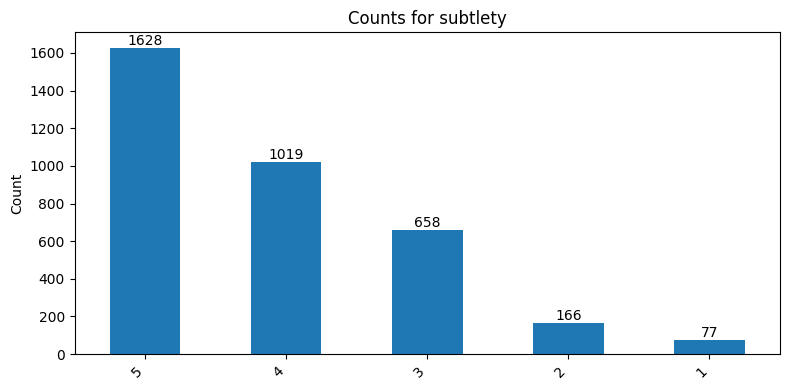

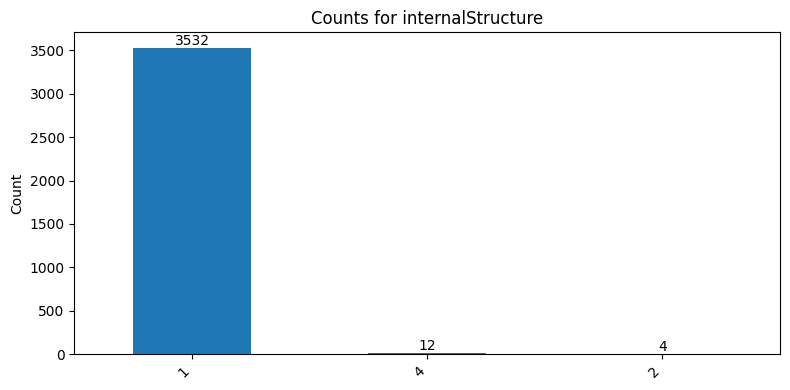

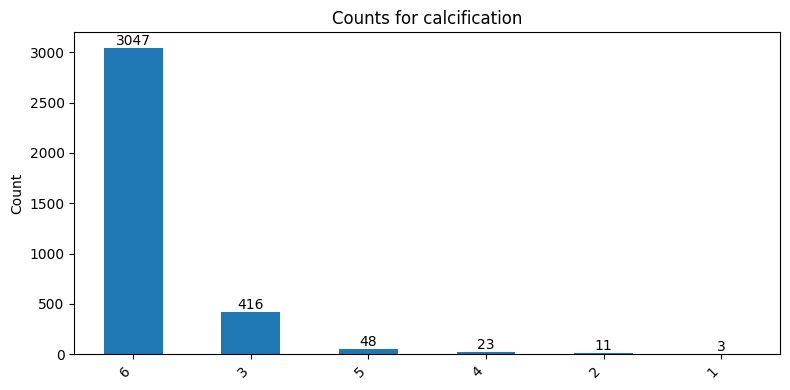

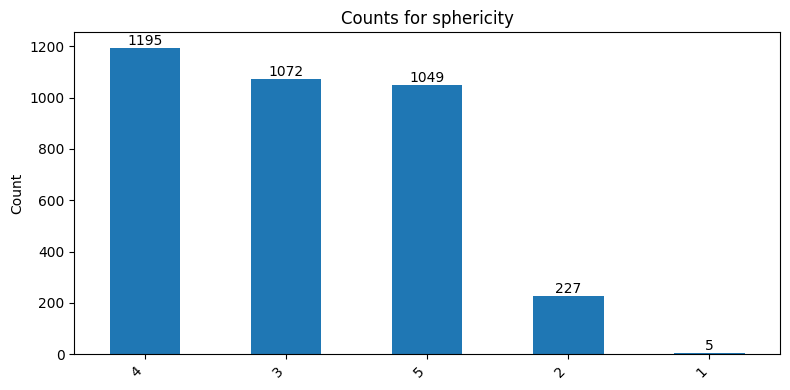

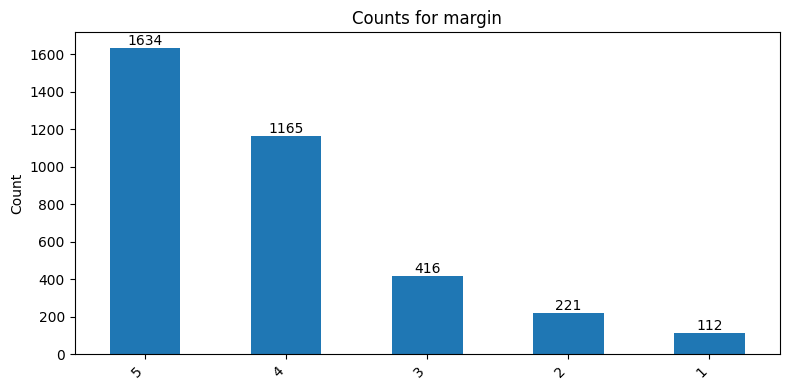

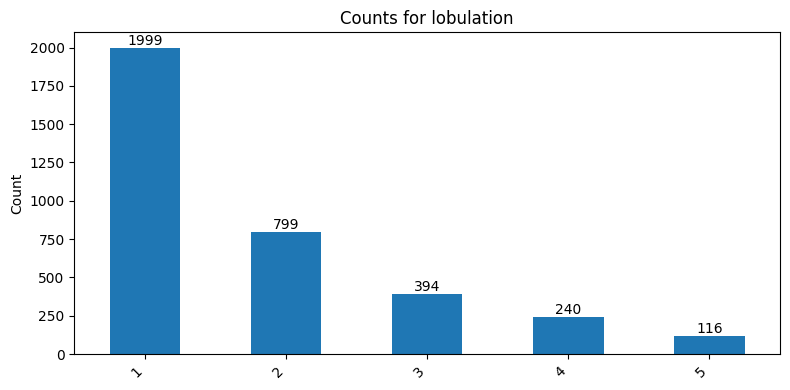

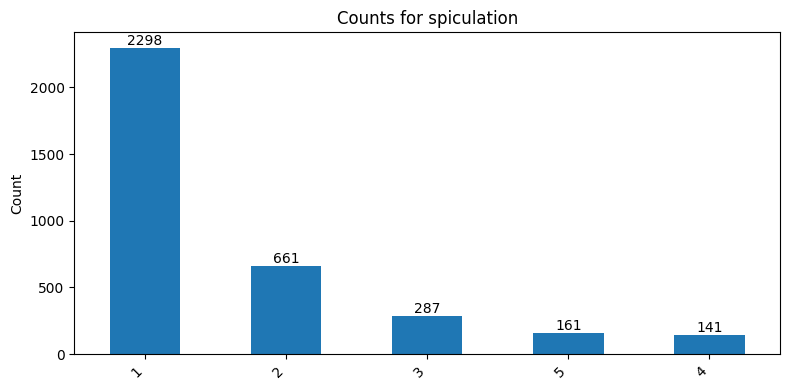

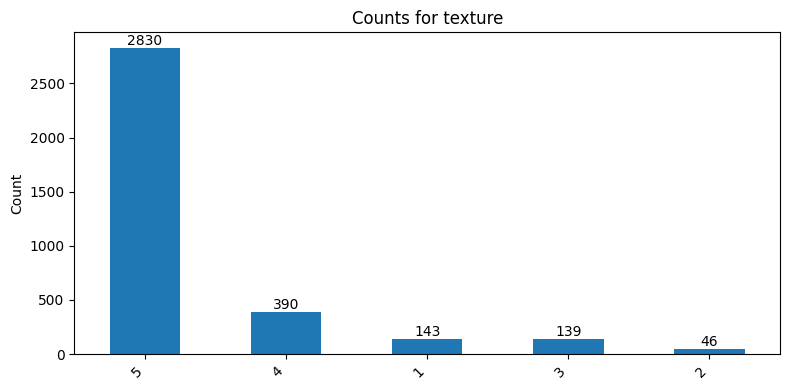

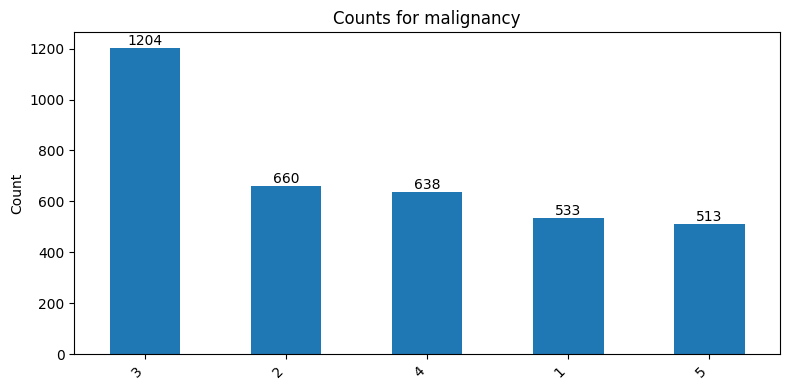

In [32]:
# Generate a bar plot for each feature
def generate_bar_plots(feature_values):
    for feature, values in feature_values.items():
        counts = pd.Series(values).value_counts()
        plt.figure(figsize=(8, 4))
        ax = counts.plot(kind='bar')
        plt.title(f'Counts for {feature}')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        
        for i, v in enumerate(counts):
            ax.text(i, v, str(v), ha='center', va='bottom')
        
        plt.tight_layout()
        plt.savefig(f'{feature}_bar_plot.png', bbox_inches='tight')
        plt.show()


generate_bar_plots(feature_values)